The 2012 US Army Anthropometric Survey (ANSUR II) was executed by the Natick Soldier Research, Development and Engineering Center (NSRDEC) from October 2010 to April 2012 and is comprised of personnel representing the total US Army force to include the US Army Active Duty, Reserves, and National Guard. In addition to the anthropometric and demographic data described below, the ANSUR II database also consists of 3D whole body, foot, and head scans of Soldier participants. These 3D data are not publicly available out of respect for the privacy of ANSUR II participants. The data from this survey are used for a wide range of equipment design, sizing, and tariffing applications within the military and has many potential commercial, industrial, and academic applications.

The ANSUR II working databases contain 93 anthropometric measurements which were directly measured, and 15 demographic/administrative variables explained below. The ANSUR II Male working database contains a total sample of 4,082 subjects. The ANSUR II Female working database contains a total sample of 1,986 subjects.


data dict:
https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf


Hİnt for metric : Our mission to classify soldiers races via their body sclales. We want a balanced score for our predictions.

# Import libraries

In [1]:
import pyforest
# Basic Libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

import pyforest
# Visualizations Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline

# Modelling Libraries
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier,PassiveAggressiveClassifier,LogisticRegressionCV
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC,LinearSVC,NuSVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier 

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score,mean_absolute_error,mean_squared_error,r2_score,confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix,plot_roc_curve,roc_auc_score,f1_score,recall_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold

from sklearn.impute import SimpleImputer

plt.rcParams["figure.figsize"] = (10,6)
pd.set_option("max_columns",100)
pd.set_option("max_rows",900)
pd.set_option("max_colwidth",200)

# Ingest the data from links below and make a dataframe
- Soldiers Male : https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr
- Soldiers Female : https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq

In [2]:
dataset_male = pd.read_csv("ANSUR II MALE Public.csv")

In [3]:
dataset_female = pd.read_csv("ANSUR II FEMALE Public.csv")

# EDA
Tips :
- Drop unnecessary colums
- Drop DODRace class if value count below 500 (we assume that our data model can't learn if it is below 500)
- Find unusual value in Weightlbs

In [4]:
dataset_female.columns == dataset_male.columns

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [5]:
def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(dataset_male)[:2]

,Missing_Number,Missing_Percent
Ethnicity,3180,0.77903
subjectid,0,0.00000


In [6]:
missing(dataset_female)[:2]

,Missing_Number,Missing_Percent
Ethnicity,1467,0.738671
SubjectId,0,0.000000


In [7]:
dataset_female.rename(columns={"SubjectId":"subjectid"},inplace=True)

In [8]:
dataset = pd.concat([dataset_female,dataset_male],axis=0)
dataset.sample(3)

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,...,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
2896,26953,213,1378,348,228,1282,254,206,440,354,246,520,72,342,307,140,969,221,898,626,509,395,1459,279,1052,258,1262,857,569,344,34,60,22,163,756,103,282,353,284,545,501,1134,84,205,200,147,566,201,335,75,...,498,74,404,129,385,432,1375,121,433,282,1240,383,168,864,960,635,1918,1707,1398,1106,602,173,844,462,127,921,1502,413,281,811,198,355,1068,782,171,761,Male,15-Dec-11,Fort Gordon,Regular Army,Combat Service Support,25Q,Georgia,2,NaN,2,22,67,172,Left hand
3182,27574,263,1522,361,230,1406,260,205,442,387,306,528,76,340,325,144,1114,261,931,640,528,404,1599,299,1151,281,1387,898,697,381,39,65,21,236,821,103,273,370,323,562,499,1196,92,220,198,160,575,198,360,71,...,531,79,407,120,386,422,1498,121,466,275,1218,388,152,952,939,631,1876,1840,1521,1191,656,196,884,494,133,942,1767,495,352,980,242,403,1123,955,181,902,Male,28-Jan-12,Fort Huachuca,Regular Army,Combat Service Support,351M,Louisiana,1,NaN,1,34,73,205,Right hand
684,18143,214,1307,307,225,1240,231,188,365,269,256,400,65,313,286,125,946,220,796,559,458,408,1384,234,773,187,1181,783,648,386,31,54,20,218,741,94,249,320,256,440,438,999,73,173,180,142,544,188,315,67,...,481,65,421,110,316,345,1330,112,374,244,945,334,147,850,800,535,1644,1604,1308,1065,595,156,716,440,117,816,1523,419,259,767,198,366,972,595,149,773,Female,6-Jul-11,Fort Lee,Regular Army,Combat Support,91J,New Jersey,23,Puerto Rican,3,25,63,125,Right hand


In [9]:
df = dataset.copy()
df.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,...,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,263,466,65,338,301,141,1011,223,836,587,476,360,1336,274,922,245,1095,759,557,310,35,65,16,220,713,91,246,316,265,517,432,1028,75,182,184,141,548,191,314,69,...,447,55,404,118,335,368,1268,113,362,235,1062,327,148,803,809,513,1647,1560,1280,1013,622,174,736,430,110,844,1488,406,295,850,217,345,942,657,152,756,Female,5-Oct-10,Fort Hood,Regular Army,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,250,430,64,294,270,126,893,186,900,583,483,350,1440,261,839,206,1234,835,549,329,32,60,23,208,726,91,249,341,247,468,463,1117,78,187,189,138,535,180,307,60,...,492,69,334,115,302,345,1389,110,426,259,1014,346,142,835,810,575,1751,1665,1372,1107,524,152,771,475,125,901,1470,422,254,708,168,329,1032,534,155,815,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,276,450,69,309,270,128,987,204,861,583,466,384,1451,287,874,223,1226,821,643,374,36,65,26,204,790,100,265,343,262,488,469,1060,84,198,195,146,588,207,331,70,...,469,64,401,135,325,369,1414,122,398,258,1049,362,164,904,855,568,1779,1711,1383,1089,577,164,814,458,129,882,1542,419,269,727,159,367,1035,663,162,799,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,276,484,68,340,294,144,1012,253,897,599,471,372,1430,269,1008,285,1170,804,640,351,38,62,22,244,775,97,265,331,309,529,455,1069,80,192,186,153,593,206,332,68,...,478,67,402,118,357,386,1329,115,394,250,1121,333,157,875,815,536,1708,1660,1358,1065,679,187,736,463,125,866,1627,451,302,923,235,371,999,782,173,818,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,336,525,67,300,295,135,1281,284,811,607,467,433,1362,305,1089,290,1112,726,686,356,34,65,18,233,732,88,247,339,260,596,447,1039,78,183,187,140,522,181,308,63,...,441,63,479,114,340,358,1350,116,345,242,1151,329,156,824,810,559,1702,1572,1292,1030,766,197,766,429,116,800,1698,452,405,1163,300,380,911,886,152,762,Female,5-Oct-10,Fort Hood,Regular Army,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right ha

In [10]:
df.shape

(6068, 108)

In [11]:
df.drop(columns=["Date","subjectid","Component","SubjectNumericRace","SubjectsBirthLocation","Branch","PrimaryMOS","Ethnicity","WritingPreference","Installation",],inplace=True)

In [12]:
df = df.drop(["axillaheight","cervicaleheight","chestheight","kneeheightsitting","suprasternaleheight","stature","stature","tenthribheight","waistheightomphalion","wristheight","trochanterionheight"],axis=1)

In [13]:
def color(val):
    if val > 0.85 and val < 0.99:
        color = 'darkgreen'
    elif val ==1 :
        color="black"
    elif abs(val) < 0.10:
        color="red"
    else:
        color = 'white'
    return f'color: {color}'
pd.DataFrame(df).corr().style.applymap(color)

In [14]:
df.shape

(6068, 88)

In [15]:
df.Gender.value_counts()

Male      4082
Female    1986
Name: Gender, dtype: int64

In [16]:
df.Gender = [1 if i == "Male" else 0 for i in df.Gender]

In [17]:
df.Gender.value_counts()

1    4082
0    1986
Name: Gender, dtype: int64

In [18]:
df.DODRace.value_counts()

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64

In [19]:
df = df[df.DODRace.isin([1,2,3])]

# DATA Preprocessing

In [20]:
X = df.drop(columns="DODRace")
y= df.DODRace

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelling Implementing
- You can research over/undersampling methods and after selecting the best model, examine it to see if better scores can be obtained. (https://imbalanced-learn.org/stable/introduction.html)

## 1. Logistic Regression

In [23]:
log_model =LogisticRegression(class_weight="balanced").fit(X_train_scaled,y_train)
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_log_proba(X_train_scaled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[622  21 155]
 [  4 209  18]
 [ 26  12  87]]
              precision    recall  f1-score   support

           1       0.95      0.78      0.86       798
           2       0.86      0.90      0.88       231
           3       0.33      0.70      0.45       125

    accuracy                           0.80      1154
   macro avg       0.72      0.79      0.73      1154
weighted avg       0.87      0.80      0.82      1154



In [24]:
scores = cross_validate(log_model,X_train_scaled,y_train,cv=10,n_jobs=-1,scoring=["precision_micro","recall_micro","f1_micro","accuracy"])
pd.DataFrame(scores)

,fit_time,score_time,test_precision_micro,test_recall_micro,test_f1_micro,test_accuracy
0,0.609771,0.006005,0.779221,0.779221,0.779221,0.779221
1,0.632457,0.006046,0.820346,0.820346,0.820346,0.820346
2,0.603151,0.005000,0.787879,0.787879,0.787879,0.787879
3,0.582145,0.005008,0.803030,0.803030,0.803030,0.803030
4,0.611767,0.005557,0.824675,0.824675,0.824675,0.824675
5,0.584767,0.005022,0.804772,0.804772,0.804772,0.804772
6,0.600147,0.004002,0.800434,0.800434,0.800434,0.800434
7,0.606586,0.005589,0.772234,0.772234,0.772234,0.772234
8,0.643160,0.005001,0.802603,0.802603,0.802603,0.802603
9,0.621157,0.003999,0.798265,0.798265,0.798265,0.798265


In [25]:
params = {"C" : np.logspace(1,10,20),
          "l1_ratio" : [0.01,0.1,0.2,0.5,1],
          "penalty" : ["l1","l2"]}
log_mod_grid = GridSearchCV(log_model,param_grid=params , scoring = "recall_micro" ,n_jobs = -1,cv=10)

In [26]:
log_mod_grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e+01, 2.97635144e+01, 8.85866790e+01, 2.63665090e+02,
       7.84759970e+02, 2.33572147e+03, 6.95192796e+03, 2.06913808e+04,
       6.15848211e+04, 1.83298071e+05, 5.45559478e+05, 1.62377674e+06,
       4.83293024e+06, 1.43844989e+07, 4.28133240e+07, 1.27427499e+08,
       3.79269019e+08, 1.12883789e+09, 3.35981829e+09, 1.00000000e+10]),
                         'l1_ratio': [0.01, 0.1, 0.2, 0.5, 1],
                         'penalty': ['l1', 'l2']},
             scoring='recall_micro')

In [27]:
y_pred = log_mod_grid.predict(X_test_scaled)
print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = log_mod_grid.predict(X_train_scaled)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

-------Test Scores-------
[[618  19 161]
 [  4 208  19]
 [ 26  12  87]]
              precision    recall  f1-score   support

           1       0.95      0.77      0.85       798
           2       0.87      0.90      0.89       231
           3       0.33      0.70      0.44       125

    accuracy                           0.79      1154
   macro avg       0.72      0.79      0.73      1154
weighted avg       0.87      0.79      0.82      1154

-------Train Scores-------
[[2396   50  548]
 [  29  964   74]
 [  99   50  405]]
              precision    recall  f1-score   support

           1       0.95      0.80      0.87      2994
           2       0.91      0.90      0.90      1067
           3       0.39      0.73      0.51       554

    accuracy                           0.82      4615
   macro avg       0.75      0.81      0.76      4615
weighted avg       0.87      0.82      0.83      4615



## 2. Support Vector Classifier

In [28]:
svm_model = SVC(class_weight="balanced",random_state=42)
svm_model.fit(X_train_scaled,y_train)
y_pred = svm_model.predict(X_test_scaled)
print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = svm_model.predict(X_train_scaled)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

-------Test Scores-------
[[660  17 121]
 [  4 211  16]
 [ 28  13  84]]
              precision    recall  f1-score   support

           1       0.95      0.83      0.89       798
           2       0.88      0.91      0.89       231
           3       0.38      0.67      0.49       125

    accuracy                           0.83      1154
   macro avg       0.74      0.80      0.76      1154
weighted avg       0.88      0.83      0.84      1154

-------Train Scores-------
[[2599   40  355]
 [  21 1011   35]
 [  65   27  462]]
              precision    recall  f1-score   support

           1       0.97      0.87      0.92      2994
           2       0.94      0.95      0.94      1067
           3       0.54      0.83      0.66       554

    accuracy                           0.88      4615
   macro avg       0.82      0.88      0.84      4615
weighted avg       0.91      0.88      0.89      4615



In [29]:
%%time
param_grid = {'C': [100,150],
              'gamma': [0.01,0.001]}

svm_model_grid = GridSearchCV(svm_model, param_grid, scoring = "f1_micro", n_jobs = -1)
svm_model_grid.fit(X_train_scaled, y_train)
y_pred = svm_model_grid.predict(X_test_scaled)

print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = svm_model_grid.predict(X_train_scaled)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

-------Test Scores-------
[[730  15  53]
 [ 12 206  13]
 [ 59  11  55]]
              precision    recall  f1-score   support

           1       0.91      0.91      0.91       798
           2       0.89      0.89      0.89       231
           3       0.45      0.44      0.45       125

    accuracy                           0.86      1154
   macro avg       0.75      0.75      0.75      1154
weighted avg       0.86      0.86      0.86      1154

-------Train Scores-------
[[2994    0    0]
 [   0 1067    0]
 [   0    0  554]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      1067
           3       1.00      1.00      1.00       554

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615

Wall time: 12.1 s


## 3. Random Forest

In [30]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=42,n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = rf_model.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

-------Test Scores-------
[[785  12   1]
 [ 58 173   0]
 [109   8   8]]
              precision    recall  f1-score   support

           1       0.82      0.98      0.90       798
           2       0.90      0.75      0.82       231
           3       0.89      0.06      0.12       125

    accuracy                           0.84      1154
   macro avg       0.87      0.60      0.61      1154
weighted avg       0.85      0.84      0.80      1154

-------Train Scores-------
[[2994    0    0]
 [   0 1067    0]
 [   0    0  554]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      1067
           3       1.00      1.00      1.00       554

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [31]:
scores = cross_validate(rf_model,X_train_scaled,y_train,cv=10,n_jobs=-1,scoring=["precision_micro","recall_micro","f1_micro","accuracy"])
pd.DataFrame(scores)

,fit_time,score_time,test_precision_micro,test_recall_micro,test_f1_micro,test_accuracy
0,1.704383,0.059013,0.796537,0.796537,0.796537,0.796537
1,1.811404,0.023006,0.820346,0.820346,0.820346,0.820346
2,1.723387,0.096020,0.798701,0.798701,0.798701,0.798701
3,1.623360,0.177041,0.805195,0.805195,0.805195,0.805195
4,1.689377,0.076019,0.811688,0.811688,0.811688,0.811688
5,1.513337,0.265064,0.819957,0.819957,0.819957,0.819957
6,1.710384,0.053014,0.806941,0.806941,0.806941,0.806941
7,1.571349,0.218049,0.793926,0.793926,0.793926,0.793926
8,1.573349,0.215050,0.804772,0.804772,0.804772,0.804772
9,1.684377,0.079021,0.802603,0.802603,0.802603,0.802603


In [32]:
params = {"n_estimators" : [50,100],
        "max_depth" : [None,10,20],
        "max_samples" :[None,1,0.5]}

rf_model_grid = GridSearchCV(rf_model, params, scoring = "f1_micro", n_jobs = -1)
rf_model_grid.fit(X_train_scaled, y_train)
y_pred = rf_model_grid.predict(X_test)
print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = rf_model.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

-------Test Scores-------
[[798   0   0]
 [231   0   0]
 [125   0   0]]
              precision    recall  f1-score   support

           1       0.69      1.00      0.82       798
           2       0.00      0.00      0.00       231
           3       0.00      0.00      0.00       125

    accuracy                           0.69      1154
   macro avg       0.23      0.33      0.27      1154
weighted avg       0.48      0.69      0.57      1154

-------Train Scores-------
[[2994    0    0]
 [   0 1067    0]
 [   0    0  554]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      1067
           3       1.00      1.00      1.00       554

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



## 4. XGBoost

In [33]:
xgb = XGBClassifier(random_state=42).fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = xgb.predict(X_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[16:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-------Test Scores-------
[[766  17  15]
 [ 24 201   6]
 [ 89  11  25]]
              precision    recall  f1-score   support

           1       0.87      0.96      0.91       798
           2       0.88      0.87      0.87       231
           3       0.54      0.20      0.29       125

    accuracy                           0.86      1154
   macro avg       0.76      0.68      0.69      1154
weighted avg       0.84      0.86      0.84      1154

-------Train Scores-------
[[2994    0    0]
 [   0 1067    0]
 [   0    0  554]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00  

In [34]:
feats = pd.DataFrame(index=X.columns,data=xgb.feature_importances_,columns=['Importance'])
feats

,Importance
abdominalextensiondepthsitting,0.004962
acromialheight,0.009033
acromionradialelength,0.005768
anklecircumference,0.010994
balloffootcircumference,0.006909
balloffootlength,0.006072
biacromialbreadth,0.006273
bicepscircumferenceflexed,0.006918
bicristalbreadth,0.023844
bideltoidbreadth,0.006193


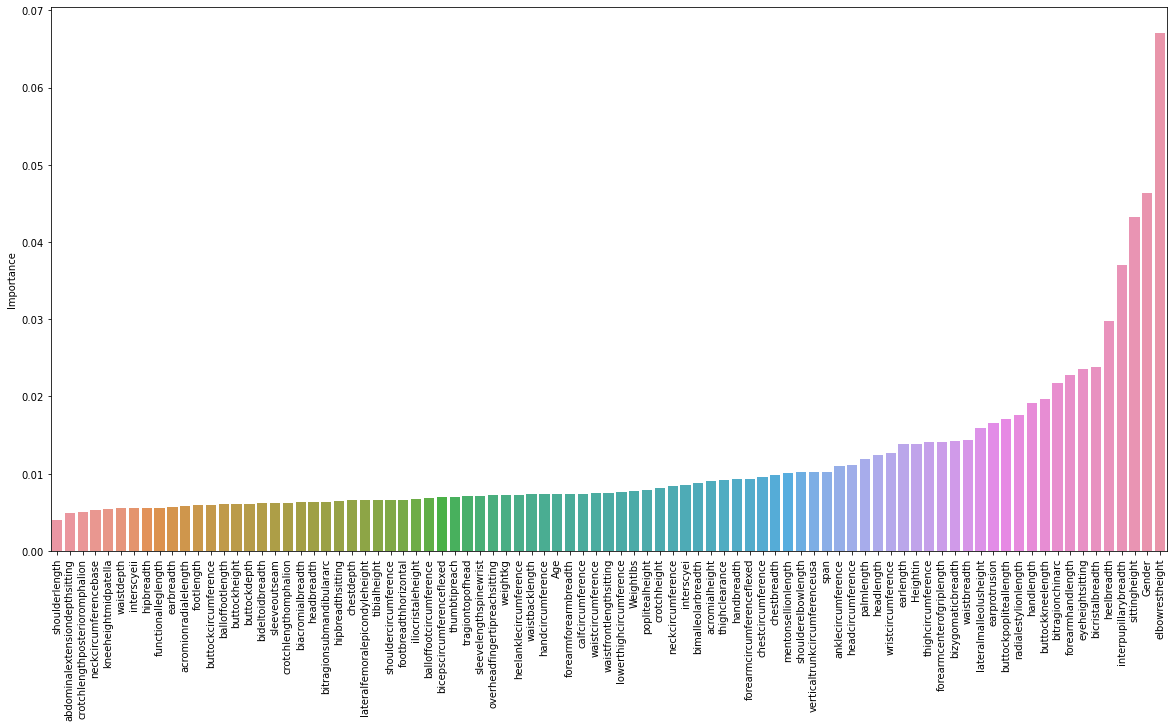

In [35]:
imp_feats = feats.sort_values("Importance")
plt.figure(figsize=(20,10))
sns.barplot(data=imp_feats.sort_values('Importance'),x=imp_feats.sort_values('Importance').index,y='Importance')

plt.xticks(rotation=90);

In [36]:
param_grid = {"n_estimators":[100],'max_depth':[3,5,6], "learning_rate": [0.1, 0.3],
             "subsample":[0.5, 1], "colsample_bytree":[0.5, 1]}
xgb_model = XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "f1_micro", verbose=2, n_jobs = -1).fit(X_train, y_train)
y_pred = xgb_grid.predict(X_test)

print("-------Test Scores-------")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

print("-------Train Scores-------")
y_pred_train = xgb_grid.predict(X_train_scaled)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[16:49:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-------Test Scores-------
[[755  13  30]
 [ 26 197   8]
 [ 82  13  30]]
              precision    recall  f1-score   support

           1       0.87      0.95      0.91       798
           2       0.88      0.85      0.87       231
           3       0.44      0.24      0.31       125

    accuracy                           0.85      1154
   macro avg       0.73      0.68      0.70      1154
weighted avg       0.83      0.85      0.84      1154

-------Train Scores-------
[[   0    0 2994]
 [   0    0 1067]
 [   0    0  554]]
              precision    recall  f1-score   support

           1       0.00      0.00    

# Choose the best model based on the metric you choose and make a random prediction

-------------------------
LOG_MODEL
[[622  21 155]
 [  4 209  18]
 [ 26  12  87]]
              precision    recall  f1-score   support

           1       0.95      0.78      0.86       798
           2       0.86      0.90      0.88       231
           3       0.33      0.70      0.45       125

    accuracy                           0.80      1154
   macro avg       0.72      0.79      0.73      1154
weighted avg       0.87      0.80      0.82      1154

-------------------------
SVM_MODEL
[[660  17 121]
 [  4 211  16]
 [ 28  13  84]]
              precision    recall  f1-score   support

           1       0.95      0.83      0.89       798
           2       0.88      0.91      0.89       231
           3       0.38      0.67      0.49       125

    accuracy                           0.83      1154
   macro avg       0.74      0.80      0.76      1154
weighted avg       0.88      0.83      0.84      1154

-------------------------
RF_MODEL
[[785  12   1]
 [ 58 173   0]
 [109   8

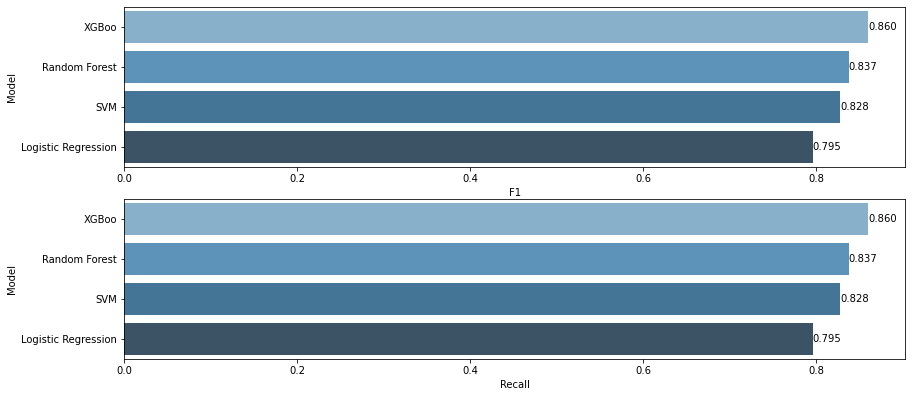

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_model=LogisticRegression(random_state=42,class_weight="balanced")
log_model.fit(X_train_scaled, y_train)
y_pred=log_model.predict(X_test_scaled)
log_f1 = f1_score(y_test, y_pred,average="micro")
log_recall = recall_score(y_test, y_pred,average="micro")
print("-------------------------")
print("LOG_MODEL")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

svm_model = SVC(random_state=42,class_weight="balanced")
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
svc_f1 = f1_score(y_test, y_pred,average="micro")
svc_recall = recall_score(y_test, y_pred,average="micro")

print("-------------------------")
print("SVM_MODEL")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

rf_model = RandomForestClassifier(random_state=42,class_weight="balanced")
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
y_pred_train =rf_model.predict(X_train)
rf_f1 = f1_score(y_test, y_pred,average="micro")
rf_recall = recall_score(y_test, y_pred,average="micro")

print("-------------------------")
print("RF_MODEL")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


xgb = XGBClassifier(random_state=42).fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_train =xgb.predict(X_train)
xgb_f1 = f1_score(y_test, y_pred,average="micro")
xgb_recall = recall_score(y_test, y_pred,average="micro")

print("-------------------------")
print("XGB_MODEL")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))




compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "Random Forest", "XGBoo"],
                        "F1": [log_f1, svc_f1, rf_f1, xgb_f1],
                        "Recall": [log_recall, svc_recall, rf_recall, xgb_recall]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

---
---